In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from keras.preprocessing import image


In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization, 
                          Conv2D, Conv2DTranspose, concatenate)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization, 
                          Conv2D, Conv2DTranspose, concatenate)
from keras.preprocessing import image  # Add this import statement


In [5]:
# Загрузка данных из файла с классами
class_dict = pd.read_csv('../Lesson_6.Segmentation/CamVid/class_dict.csv')

In [6]:
class_dict

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0
5,Car,64,0,128
6,CartLuggagePram,64,0,192
7,Child,192,128,64
8,Column_Pole,192,192,128
9,Fence,64,64,128


In [7]:
# Пути к директориям с данными
path_train = '../Lesson_6.Segmentation/CamVid/train/'
path_train_labels = '../Lesson_6.Segmentation/CamVid/train_labels/'
path_test = '../Lesson_6.Segmentation/CamVid/test/'
path_test_labels = '../Lesson_6.Segmentation/CamVid/test_labels/'
path_val = '../Lesson_6.Segmentation/CamVid/val/'
path_val_labels = '../Lesson_6.Segmentation/CamVid/val_labels/'

In [8]:
# Получение списков путей к изображениям и маскам
train_imgs_paths = list(sorted(Path(path_train).iterdir()))
train_masks_paths = list(sorted(Path(path_train_labels).iterdir()))
test_imgs_paths = list(sorted(Path(path_test).iterdir()))
test_masks_paths = list(sorted(Path(path_test_labels).iterdir()))
val_imgs_paths = list(sorted(Path(path_val).iterdir()))
val_masks_paths = list(sorted(Path(path_val_labels).iterdir()))

In [9]:
# Задаем единый размер изображений
image_size = (128, 192)

In [10]:
#В версии Keras, используемой в данной среде, метод load_img недоступен в модуле keras.preprocessing.image.
#Вместо этого  можно использовать функцию Image из библиотеки PIL (Pillow), которая также поддерживает загрузку изображений. 
from PIL import Image

# Загрузка изображений и масок в память
train_images = [Image.open(i_img).resize(image_size) for i_img in train_imgs_paths]
train_masks = [Image.open(i_mask).resize(image_size) for i_mask in train_masks_paths]
test_images = [Image.open(i_img).resize(image_size) for i_img in test_imgs_paths]
test_masks = [Image.open(i_mask).resize(image_size) for i_mask in test_masks_paths]
val_images = [Image.open(i_img).resize(image_size) for i_img in val_imgs_paths]
val_masks = [Image.open(i_mask).resize(image_size) for i_mask in val_masks_paths]

#Здесь мы используем функцию Image.open из библиотеки PIL для загрузки изображений и масок,
#а затем изменяем размеры изображений до заданного image_size с помощью метода resize.

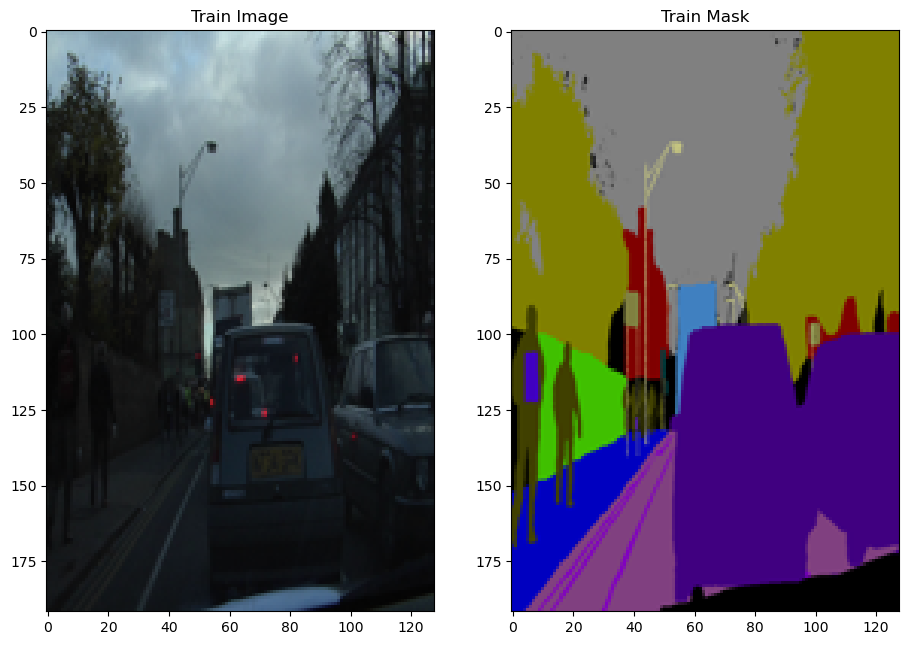

In [11]:
# Отображение некоторых изображений и масок
fig, ax = plt.subplots(1, 2, figsize=(11, 11))
ax[0].imshow(train_images[1].convert('RGBA'))
ax[0].set_title("Train Image")
ax[1].imshow(train_masks[1].convert('RGBA'))
ax[1].set_title("Train Mask")
plt.show()

In [12]:
#метод img_to_array также недоступен в модуле keras.preprocessing.image
from PIL import Image

# Преобразование изображений в массивы NumPy
X_train = np.array([np.array(img) for img in train_images])
X_test = np.array([np.array(img) for img in test_images])
X_val = np.array([np.array(img) for img in val_images])

In [13]:
# Функция для преобразования цветных масок в индексы классов
def color_to_index(y, class_dict):
    # Размер изображения
    img_size = y.shape[:2]
    # Создание массива с индексами классов
    y_index = np.zeros(img_size)
    # Перебор классов и присвоение индексов
    for i, color in enumerate(class_dict):
        y_index[(y == color).all(axis=2)] = i
    return y_index

In [14]:
# Преобразование масок в индексы классов
#y_train = np.array([color_to_index(image.img_to_array(mask), class_dict)[0] for mask in train_masks])
#y_test = np.array([color_to_index(image.img_to_array(mask), class_dict)[0] for mask in test_masks])
#y_val = np.array([color_to_index(image.img_to_array(mask), class_dict)[0] for mask in val_masks])

#метод img_to_array также недоступен в модуле keras.preprocessing.image

# Преобразование масок в индексы классов
y_train = np.array([color_to_index(np.array(mask), class_dict)[0] for mask in train_masks])
y_test = np.array([color_to_index(np.array(mask), class_dict)[0] for mask in test_masks])
y_val = np.array([color_to_index(np.array(mask), class_dict)[0] for mask in val_masks])


In [15]:
# Вывод размеров обучающего и тестового наборов
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (369, 192, 128, 3)
y_train shape: (369, 128)
X_test shape: (232, 192, 128, 3)
y_test shape: (232, 128)
X_val shape: (100, 192, 128, 3)
y_val shape: (100, 128)


In [16]:
def unet_pre_train(num_classes=32, input_shape=(128, 162, 3)):    

    # Пути к директориям с данными
    path_train = '../Lesson_6.Segmentation/CamVid/train/'
    path_train_labels = '../Lesson_6.Segmentation/CamVid/train_labels/'
    path_test = '../Lesson_6.Segmentation/CamVid/test/'
    path_test_labels = '../Lesson_6.Segmentation/CamVid/test_labels/'
    path_val = '../Lesson_6.Segmentation/CamVid/val/'
    path_val_labels = '../Lesson_6.Segmentation/CamVid/val_labels/'

    # Получение списков путей к изображениям и маскам
    train_imgs_paths = list(sorted(Path(path_train).iterdir()))
    train_masks_paths = list(sorted(Path(path_train_labels).iterdir()))
    test_imgs_paths = list(sorted(Path(path_test).iterdir()))
    test_masks_paths = list(sorted(Path(path_test_labels).iterdir()))
    val_imgs_paths = list(sorted(Path(path_val).iterdir()))
    val_masks_paths = list(sorted(Path(path_val_labels).iterdir()))

    # Загрузка изображений и масок в память
    train_images = [Image.open(i_img).resize(image_size) for i_img in train_imgs_paths]
    train_masks = [Image.open(i_mask).resize(image_size) for i_mask in train_masks_paths]
    test_images = [Image.open(i_img).resize(image_size) for i_img in test_imgs_paths]
    test_masks = [Image.open(i_mask).resize(image_size) for i_mask in test_masks_paths]
    val_images = [Image.open(i_img).resize(image_size) for i_img in val_imgs_paths]
    val_masks = [Image.open(i_mask).resize(image_size) for i_mask in val_masks_paths]

#    # Преобразование изображений в массивы NumPy
#    X_train = np.array([np.array(img) for img in train_images])
#    X_test = np.array([np.array(img) for img in test_images])
#    X_val = np.array([np.array(img) for img in val_images])

#    # Преобразование масок в индексы классов
#    y_train = np.array([color_to_index(image.img_to_array(mask), class_dict) for mask in train_masks])
#    y_test = np.array([color_to_index(image.img_to_array(mask), class_dict) for mask in test_masks])
#    y_val = np.array([color_to_index(image.img_to_array(mask), class_dict) for mask in val_masks])

    # Преобразование изображений в массивы NumPy
    X_train = np.array([np.array(img) for img in train_images])
    X_test = np.array([np.array(img) for img in test_images])
    X_val = np.array([np.array(img) for img in val_images])

    # Преобразование масок в индексы классов
    def color_to_index(y, class_dict):
        y_index = np.zeros(y.shape[:2])
        for i, color in enumerate(class_dict[['r', 'g', 'b']].values):
            ind_i = np.where((y[..., :3] == color).all(axis=-1))
            y_index[ind_i[0], ind_i[1]] = i
        return y_index

    y_train = np.array([color_to_index(np.array(mask), class_dict) for mask in train_masks])
    y_test = np.array([color_to_index(np.array(mask), class_dict) for mask in test_masks])
    y_val = np.array([color_to_index(np.array(mask), class_dict) for mask in val_masks])


    # Предварительная обработка входных изображений для VGG16
    X_train = preprocess_input(X_train)
    X_test = preprocess_input(X_test)
    X_val = preprocess_input(X_val)

    # Загрузка предварительно обученной модели VGG16
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

    # Замораживание первых 13 слоев
    for layer in pre_trained_model.layers[:-5]:
        layer.trainable = False

    # Получение выходов блоков из модели VGG16
    x = pre_trained_model.layers[13].output
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    img_input = pre_trained_model.inputs

    # UP 1
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Выходной слой с функцией активации softmax
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    # Создание модели
    model = Model(img_input, x)
    return model


In [17]:
# Задание параметров для функции unet_pre_train
num_classes = 32
input_shape = (128, 162, 3)

In [ ]:
# Создание модели U-Net с предварительно обученным VGG16
model = unet_pre_train(num_classes=num_classes, input_shape=input_shape)